In [2]:
import os
import cv2
import uuid
import time

In [3]:
uuid.uuid1()

UUID('85540fce-1036-11ee-be21-30c9abd590fa')

In [4]:
IMAGE_PATH = os.path.join('data', 'images')
number_images = 30

In [12]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
  print('Collecting images {}'.format(imgnum))
  ret, frame = cap.read()
  imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

In [16]:
!labelme

External WM_DESTROY received for  QWidgetWindow(0x1f1063c9600, name="FilesWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1f105dfde60, name="MainWindowClassWindow")
External WM_DESTROY received for  QWidgetWindow(0x1f1064a24d0, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1f105dfde60, name="MainWindowClassWindow")


### Reviewing Dataset and Building Image Loading Function

In [17]:
import tensorflow as tf
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
tf.config.list_physical_devices('GPU')

[]

In [55]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [56]:
images.as_numpy_iterator().next()

b'data\\images\\6db2791c-103a-11ee-a130-30c9abd590fa.jpg'

In [57]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [58]:
images = images.map(load_image)

In [59]:
images.as_numpy_iterator().next()

array([[[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [120, 112,  93],
        [118, 110,  91],
        [110, 102,  83]],

       [[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [124, 115,  98],
        [117, 108,  91],
        [112, 103,  86]],

       [[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [128, 116, 102],
        [118, 106,  92],
        [115, 103,  89]],

       ...,

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [157, 160, 153],
        [158, 160, 155],
        [161, 163, 158]],

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [155, 158, 151],
        [157, 159, 154],
        [161, 163, 158]],

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [154, 157, 150],
        [156, 158, 153],
        [161, 163, 158]]

In [60]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [61]:
image_generator = images.batch(4).as_numpy_iterator()

In [72]:
plot_images = image_generator.next()

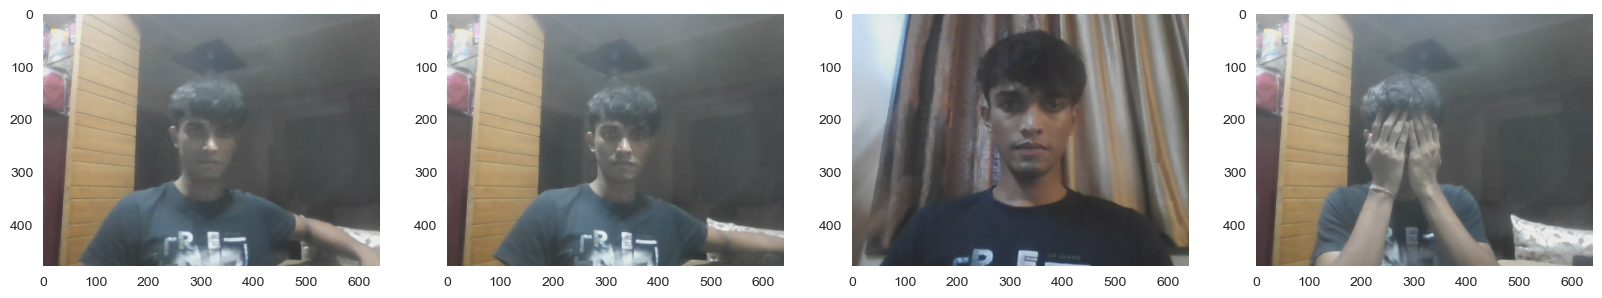

In [73]:
fig , ax = plt.subplots(ncols =4, figsize = (20,20))
for idx , image in enumerate(plot_images):
    ax[idx].imshow(image)
    ax[idx].grid(False)
plt.show()

In [78]:
#Moving labels according to the image locations
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):
        
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### Applying Image Augmentations on Images and Labels using Albumentation

In [86]:
import albumentations as alb

In [94]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height = 450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params = alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [95]:
img = cv2.imread(os.path.join('data', 'train','images','1a583291-103a-11ee-b7e6-30c9abd590fa.jpg'))

In [99]:
with open(os.path.join('data','train','labels', '1a583291-103a-11ee-b7e6-30c9abd590fa.json'), 'r') as f:
    label = json.load(f)

In [103]:
label['shapes'][0]['points']

[[291.95121951219517, 80.2439024390244], [533.4146341463415, 338.780487804878]]

In [106]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [108]:
coords

[291.95121951219517, 80.2439024390244, 533.4146341463415, 338.780487804878]

In [109]:
coords = list(np.divide(coords,[640,480,640,480]))

In [110]:
coords

[0.45617378048780494,
 0.16717479674796748,
 0.8334603658536587,
 0.7057926829268292]

In [111]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [112]:
augmented

{'image': array([[[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [191, 191, 191],
         [185, 185, 185],
         [179, 179, 179]],
 
        [[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [186, 186, 186],
         [188, 188, 188],
         [180, 180, 180]],
 
        [[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [189, 189, 189],
         [192, 192, 192],
         [181, 181, 181]],
 
        ...,
 
        [[120, 122, 123],
         [119, 121, 122],
         [120, 121, 125],
         ...,
         [ 66,  55,  47],
         [ 64,  55,  46],
         [ 64,  55,  46]],
 
        [[120, 122, 123],
         [120, 122, 123],
         [121, 122, 126],
         ...,
         [ 66,  55,  47],
         [ 65,  56,  47],
         [ 65,  56,  47]],
 
        [[120, 122, 123],
         [120, 122, 123],
         [121, 123, 124],
         ...,
         [ 65,  56,

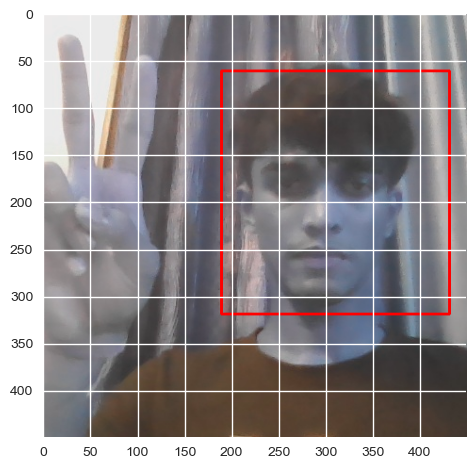

In [113]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
             (255,0,0),2)
plt.imshow(augmented['image'])